In [1]:
import pandas as pd
import os
dir_path = os.path.abspath('')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#code to format titles for the graphs to contain info on consumption, generation, use
def id_title(id, description):
    title = id + "(C,"
    if(not np.isnan(description.loc[id]['Production (kW)']) and description.loc[id]['Production (kW)']>0.0): title = title + "P,"
     
    title = title + str(description.loc[id]['Type'])

    return(title + ")")

# Data decription

Putting all smart meter data in a dataframe:

In [3]:
meters = open(dir_path+"/smart_meters.txt")
all_meter_data = pd.DataFrame()

for meter in meters:
    file_path = dir_path + '/out_CSV/15m/' + str(meter[:-1]) + '.csv'
    df = pd.read_csv(file_path, index_col=0)
    #reformating timestamps to python datetimes
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    #replace null values with 0:
    #df.fillna(0, inplace=True)
    all_meter_data = pd.concat([all_meter_data,df])
all_meter_data['timestamp'] = pd.to_datetime(all_meter_data['timestamp'])

all_meter_data = all_meter_data[all_meter_data.timestamp.dt.year != 1970]
all_meter_data = all_meter_data[all_meter_data.timestamp.dt.year != 2040]

The smart_meter_desciption file gives us information on the available smart meters, their use and wether there is generation:

In [4]:
meter_description = pd.read_csv(dir_path+'/smart_meter_description.csv', sep=';', engine='python')
meter_description.index = meter_description.ID

print("Commercial loads:", ','.join(meter_description[meter_description['Type']=="company"].ID))
print("Residential loads:", ','.join(meter_description[meter_description['Type']=="User"].ID) )
print("We also have a university(BBB6020), three water pumps (BBB007, BBB022, BBB032), a swimming pool (BBB6028) and 2 EV charging stations (BBB6103, BBB6105)")

Commercial loads: BBB6017,BBB6018,BBB6021,BBB6025,BBB6029,BBB6030,BBB6036,BBB6040,BBB6048,BBB6050,BBB6051,BBB6052,BBB6055,BBB6061,BBB6062,BBB6063,BBB6064,BBB6065,BBB6078,BBB6133
Residential loads: BBB6168,BBB6169,BBB6170,BBB6171,BBB6173,BBB6177,BBB6178,BBB6179,BBB6180,BBB6181,BBB6182,BBB6183,BBB6186,BBB6190,BBB6191,BBB6192,BBB6197,BBB6198
We also have a university(BBB6020), three water pumps (BBB007, BBB022, BBB032), a swimming pool (BBB6028) and 2 EV charging stations (BBB6103, BBB6105)


# Distribution of available data in time  
### How much data do we have for every month, day, hour?

First let's check how much data we have for each smart meter, within the period of study: 

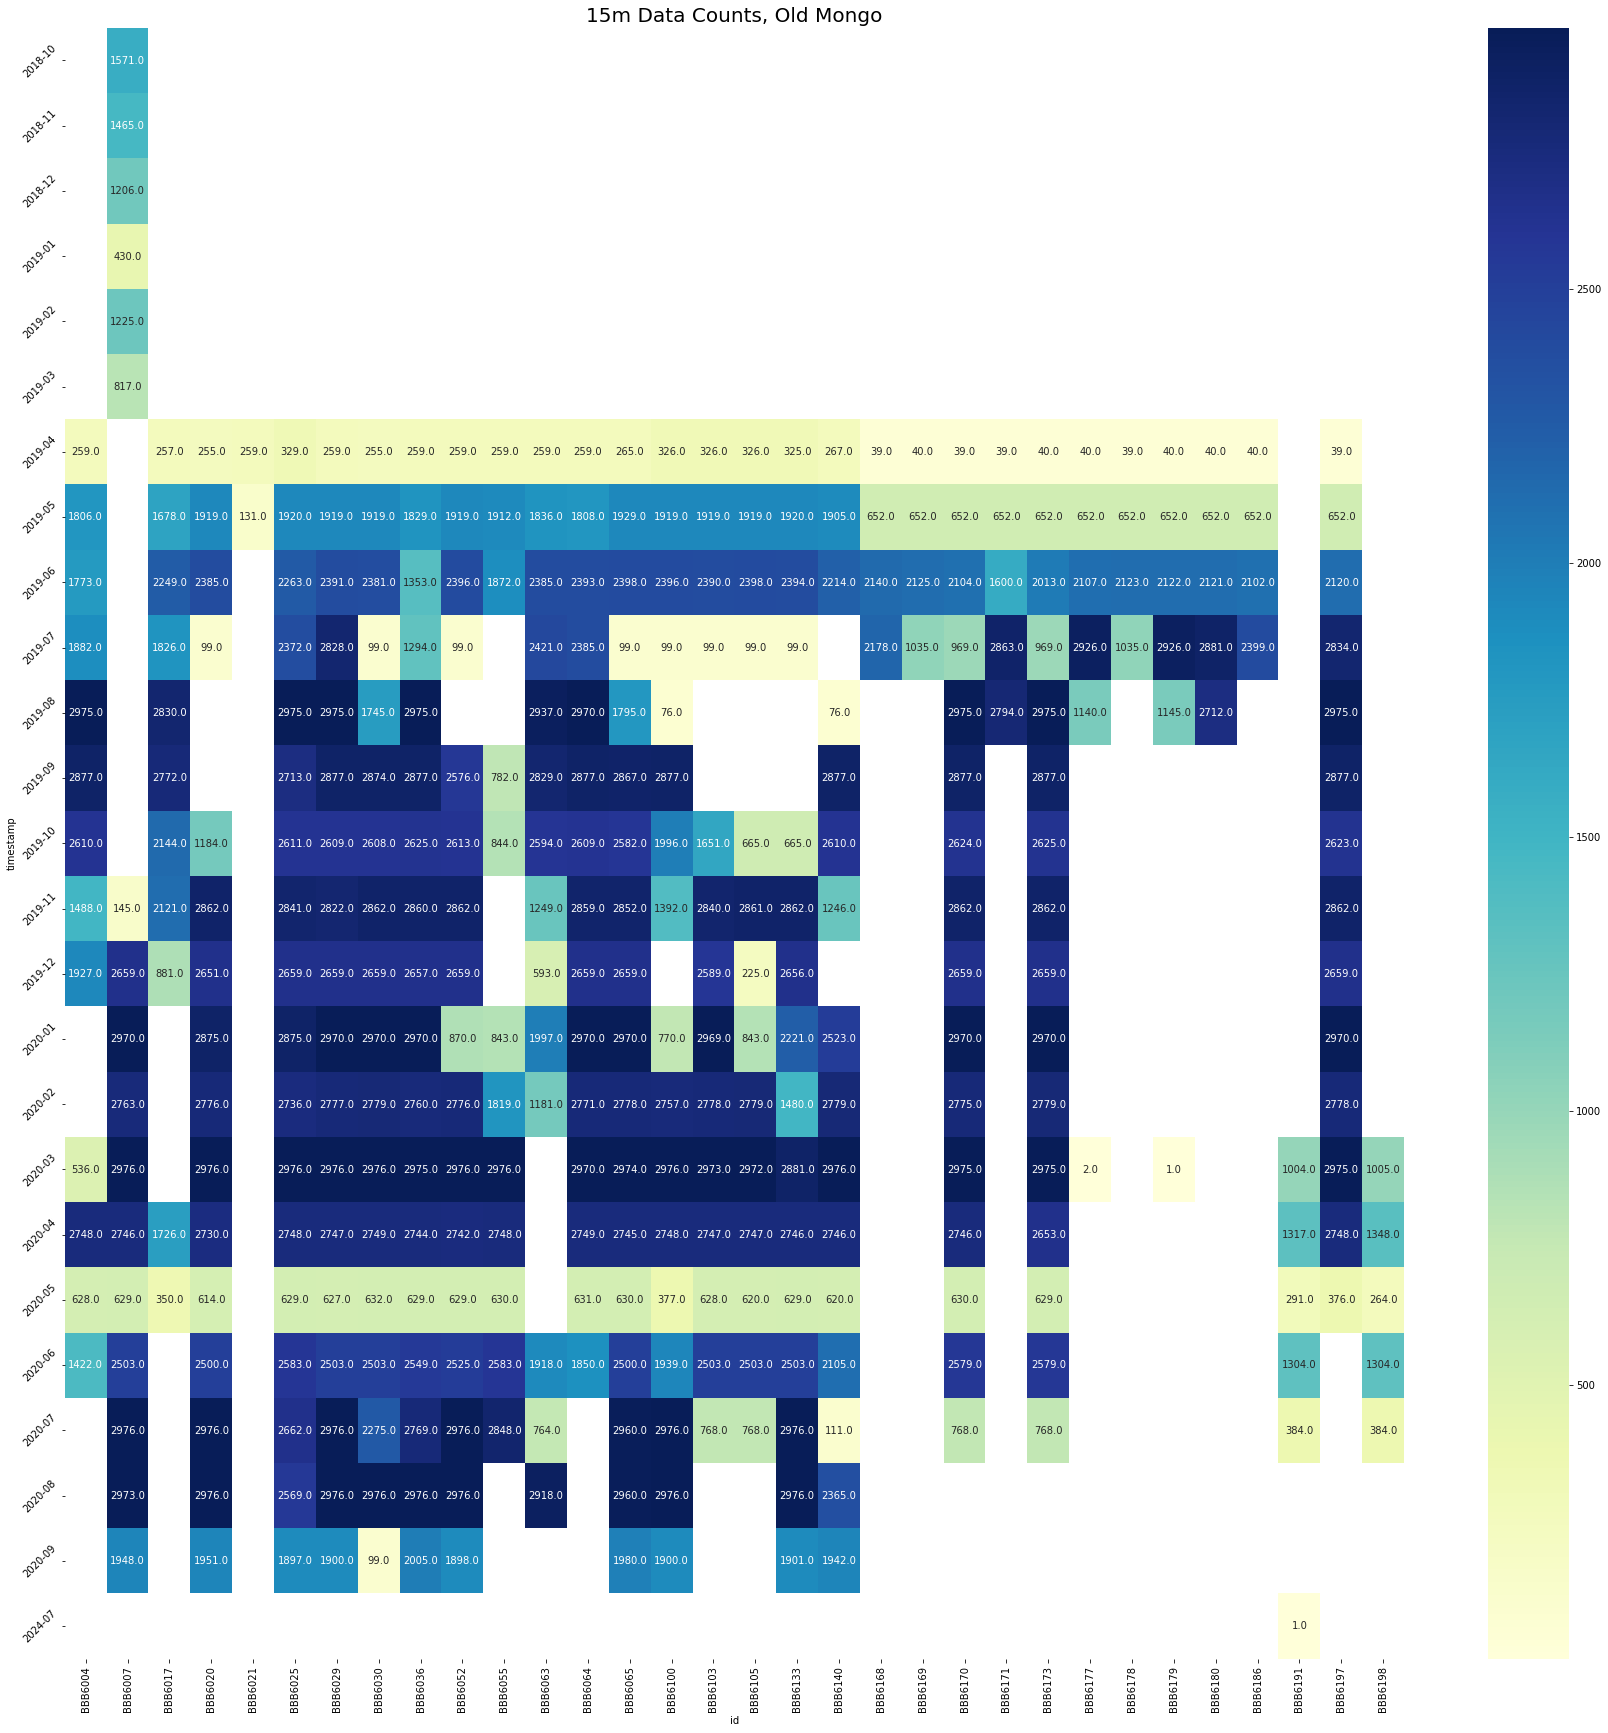

In [5]:
month_year = all_meter_data['timestamp'].groupby([all_meter_data.timestamp.dt.to_period('M'), all_meter_data.id]).agg('count').unstack()

figure, ax = plt.subplots(1, 1, figsize=(30,30))
ax.set_title("15m Data Counts, Old Mongo", fontsize=20)

ax = sns.heatmap(month_year, annot=True, cmap="YlGnBu", fmt='.1f')
plt.yticks(rotation=45)
plt.show()

figure.savefig(dir_path+'/plots&graphs/Mongo_15mDataCount.png')


### Conclusions:
1. There are wrong readings outside the period of study: multiple on 1970-01, and one on 2024-07. These should be deleted from the dataset.

2. For BBB6040, BBB6061, BBB6067, BBB6074, BBB6078, BBB6097 we only have a single datapoint. We should look for more data in the SQL database -> there is data for BBB6040 on the SQL database, but not the rest

3. Smart meters BBB6021, BBB6168, BBB6169, BBB6177, BBB6178, BBB6179, BBB6180, BBB6186, BBB6191, BBB6198 appear to have some data available, but for relatively small time periods (6 months or less, sometimes not entire months). We'll need to check them further to see which parts of the data can be used for clustering.

4. BBB6004, BBB6007, BBB6017, BBB6020, BBB6025, BBB6029, BBB6030, BBB6036, BBB6052, BBB6055, BBB6063, BBB6064, BBB6065, BBB6100, BBB6103, BBB6105, BBB6133, BBB6140, BBB6170, BBB6173, BBB6197 (21/55 smart meters) seem to have data for multiple months (more than 6 months) and often entire months.

<AxesSubplot:title={'center':'distribution of data amount'}, ylabel='ID'>

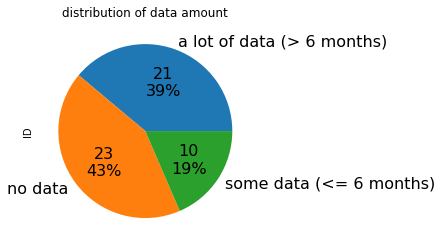

In [6]:
alotofdata = ['BBB6004', 'BBB6007', 'BBB6017', 'BBB6020', 'BBB6025', 'BBB6029', 'BBB6030', 'BBB6036', 'BBB6052', 'BBB6055', 'BBB6063', 'BBB6064', 'BBB6065', 'BBB6100', 'BBB6103', 'BBB6105', 'BBB6133', 'BBB6140', 'BBB6170', 'BBB6173', 'BBB6197'] 
somedata = ['BBB6168', 'BBB6169', 'BBB6171', 'BBB6177', 'BBB6178', 'BBB6179', 'BBB6180', 'BBB6186', 'BBB6191', 'BBB6198']

meter_description['Data Amount'] = 'no data'

meter_description.loc[meter_description['ID'].isin(alotofdata), 'Data Amount'] = "a lot of data (> 6 months)"
meter_description.loc[meter_description['ID'].isin(somedata), 'Data Amount'] = "some data (<= 6 months)"

def label_function(val):
    return f'{val / 100 * 54:.0f}\n{val:.0f}%'
meter_description.groupby('Data Amount').ID.agg('count')

meter_description.groupby('Data Amount').ID.agg('count').plot(kind='pie', title='distribution of data amount', autopct=label_function, textprops={'fontsize': 16})

Distributions of data counts across time (smart meters with a lot of data):

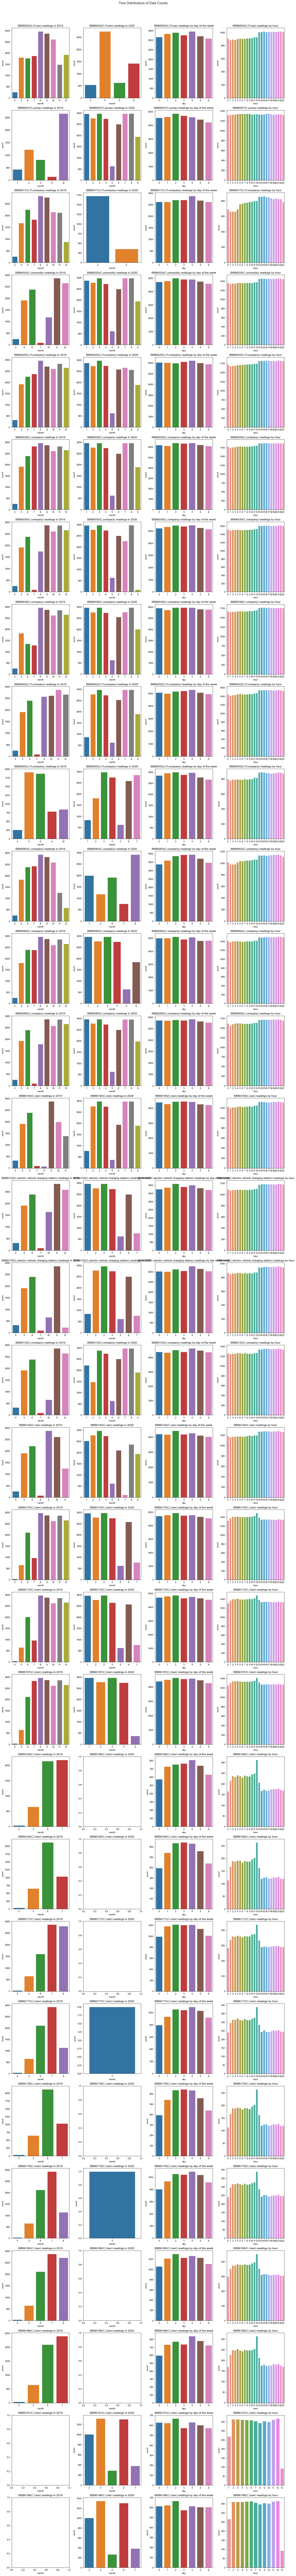

In [7]:
meters = alotofdata + somedata

figure, axis = plt.subplots(len(meters), 4, figsize=(17,len(meters)*5))
i = 0
for meter in meters:
    df = all_meter_data[all_meter_data.id == meter]
    for2019 = df[df.timestamp.dt.year==2019]
    for2020 = df[df.timestamp.dt.year==2020]

    sns.set_style("darkgrid")

    if(for2019.empty == False):
        sns.countplot(for2019.timestamp.dt.month, ax=axis[i][0])
    if(for2020.empty == False):
        sns.countplot(for2020.timestamp.dt.month, ax=axis[i][1])

    axis[i][0].set_title(id_title(meter, meter_description) + " readings in 2019")
    axis[i][1].set_title(id_title(meter, meter_description) + " readings in 2020")

    axis[i][0].set_xlabel("month")
    axis[i][1].set_xlabel("month")

    sns.countplot(df.timestamp.dt.day_of_week, ax=axis[i][2])
    sns.countplot(df.timestamp.dt.hour, ax=axis[i][3])

    axis[i][2].set_title(id_title(meter, meter_description) + " readings by day of the week")
    axis[i][3].set_title(id_title(meter, meter_description) + " readings by hour")

    axis[i][2].set_xlabel("day")
    axis[i][3].set_xlabel("hour")

    i = i+1

figure.tight_layout()
figure.subplots_adjust(top=0.97)
figure.suptitle('Time Distributions of Data Counts', fontsize=14)
figure.savefig(dir_path+'/plots&graphs/Mongo_TimeDistr.png')

Observations on missing data:

Hour-by-Hour:
1. For most of the smart meters (BBB6004-BBB6133), we seem to have more missing data in the 00:00h to 13:00h time interval. That is verified by checking the raw data. There are entire days with no data in the above interval.
2. For smart meters BBB6170, BBB6173, BBB6197 we have the opposite problem: more missing data in the 14:00h to 00:00h interval. That is peculiar. We should check with ASM wether there is any significance to those intervals.
3. For smart meters BBB6191 and BBB6198 there is only data in the 01:00h to 13:00h interval. We'll have to check with ASM about why that is. We obviously can't include them in the clustering process.
4. Smart meter BBB6021 has no data in the 01:00h to 00:06h interval and only 4 readings in the 00:07-12:00h interval.
5. Smart meters BBB6168-BBB6189 share the same hourly distribution of data. The distribution is again not uniform with more data missing in the 14:00h to 00:00h interval. 

Day-by-Day:
1. The only visible trend from the distributions is that we have fewer data on Saturdays and Sundays than on weekdays. That isn't a big problem considering that the clustering analysis will only be performed on weekdays at first.

Month-to-Month:
1. For most smart meters data starts on April of 2019 and ends on July or September of 2020. Between those dates, there are cases where entire months are missing or some months have fewer data than others. Universal problems: very few data across all smart meters for May 2020, very few data across multiple smart meters for July 2019. No data between September 2020 and December 2021 (when the SQL data starts)

# Let's work on missing data:

In [8]:
#creating a dictionary with a dataframe for each ID:
IDs = pd.unique(all_meter_data['id'])
dict = {}
for id in IDs:
    df = all_meter_data[all_meter_data['id']==id]
    df.index = df.timestamp
    #df = df.resample('15min').agg({'Active_Energy_+_Total_ini':np.min, 'Active_Energy_+_Total_end':np.max, 'Active_Energy_+_Incr':np.sum, 'Active_Energy_-_Total_ini':np.min,'Active_Energy_-_Total_end':np.max, 'Active_Energy_-_Incr':np.sum})
    dict[id] = df

meters = alotofdata + somedata


Before we move on to imputation, let's take a look at the graphs for Total Active Energy for all smart meters. For some of them, there seems to be problem: total active energy isn't increasing over time.

Text(0.5, 0.98, 'Raw Total Energy Graphs')

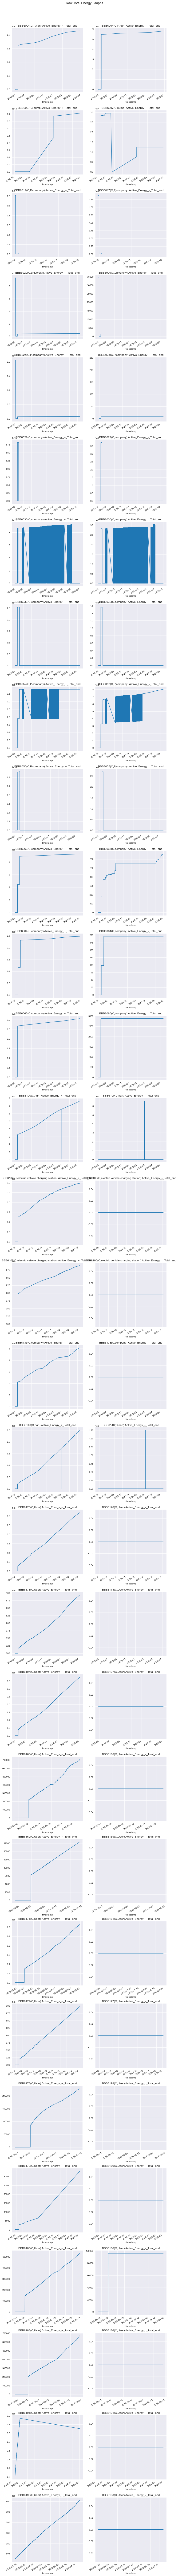

In [9]:
fig, ax = plt.subplots(len(meters), 2, figsize=(10,len(meters)*5))
i = 0

for id in meters:
    meter = dict[id].copy()

    meter['Active_Energy_+_Total_end'].plot(ax=ax[i][0])
    meter['Active_Energy_-_Total_end'].plot(ax=ax[i][1])

    
    ax[i][0].set_title(id_title(id, meter_description) + ' Active_Energy_+_Total_end')
    ax[i][1].set_title(id_title(id, meter_description) + ' Active_Energy_-_Total_end')
    

    i=i+1

fig.tight_layout()
fig.subplots_adjust(top=0.97)
fig.suptitle('Raw Total Energy Graphs', fontsize=14)

From the above graphs, we can see that in some cases the Total Energy isn't an increasing and continuous function. Those cases will need to be corrected. For smart meters (), initial values for total energy are much larger than the ones after the meter is setup correctly. 

Συμπεράσματα για κάθε smart meter:
* ΒΒΒ6030: παλινδρόμηση μεταξύ 3 σταθμών. η σωστή είναι στην αρχή 8650645440.0 (τάξη 8*10^9). Αργότερα η στάθμη αυτή πολλαπλασιάζεται επί 10^3 (τάξη 8 *10^12). Η στάθμη πέρι 290770132.00000006 (2 * 10^8) τι σχέση έχει με τις άλλες; είναι περίπου /3 η πρώτη στάθμη.

* BBB6052: Για κατανάλωση -> στην αρχή σταθμη 188965.543 (μάλλον λάθος) μετά πολλαπλασιάζεται επί 10^3 (μάλλον σωστό). μετά παλινδρόμηση μεταξύ παλινδρόμηση μεταξύ 188965543.0 και 378043646.0 (η δεύτερη στάθμη *2 της πρώτης). Για παραγωγή -> παρομοίως αρχικά στάθμη 328157.39400000003 μετά επί 10^3 (μάλλον η σωστή). Μετά παλλινδρόμηση μεταξύ 336754799.0 και 673509598.0 (δεύτερη στάθμη *2 της πρώτης)

* BBB6004, 017, 020, 025 Δεν έχουν αρχικοποιηθεί σωστά. ΒΒΒ6004 στην αρχή χρειάζεται πολλαπλασιασμό *10^3. ΒΒΒ6017 πολύ υψηλή τιμή στην αρχή, μετά θέλει *10^3. Το ίδιο και για το BBB6020. Σε όλα διορθώνονται οι στάθμες μετά τις 14/5/2019. Οπότε θα μπορούσαμε να απορρίψουμε όλες τις τιμές πριν από μία ημερομηνία και να πολλαπλασιάσουμε *10^3 όλες τις τιμές πριν τις 14/05.

* ΒΒΒ6029: Στην αρχή φαίνεται εντάξει. Μετά τις 14/05 πολλαπλασιάζεται επί 10^3 χωρίς να πρέπει. Αργότερα αλλάζει στάθμη πάλι, πέφτωντας στην στάθμη 303297681.00000006 στις 24/05/2019. Δεδομένου ότι η ονομαστική ισχύς τις εταιρείας είναι 60 kW, η αρχική στάθμη φαίνεται να είναι η σωστή. Δεν είναι ξεκάθαρο όμως. Το ίδιο παρατηρείται και για τα BBB6036 και BBB6055, μόνο που η τρίτη στάθμη μπαίνει στις 30/05/2019. Για αυτά τα 2 smart meters, η τρίτη στάθμη φαίνεται να είναι σωστή, δεδομένης της ονομαστικής ισχύος.

* BBB6063: επί 10^3 στις 14/05 του 19, μετά η στάθμη πολλαπλασιάζεται *2 στις 30/5. ποιο είναι σωστό; Παρομοίως για BBB6064.

* BBB6065: επί 10^3 στις 14/05 του 19.

* BBB6103, 105, 133, 170, 173, 197: επί 10*3 στις 14/05 του 19.

* ΒΒΒ6100, BBB6140: επί 10^3 στις 14/05 του 19 και ένα outlier value που όμως διορθώνεται από το resampling σε περίοδο μίας ώρας. 

Από τα παραπάνω προκύπτουν τα εξής συμπεράσματα:

* πρέπει να απορρίψουμε όλες τις τιμές πριν από ...
* στις 14/05/2019 οι αθροιστικές τιμές ενέργειας όλων των smart meters πολλαπλασιάζονται *10^3. Αυτό φαίνεται να είναι σωστό για τα ... και λάθος για τα ... Για τα μεν θα πρέπει να πολλαπλασιάσουμε όλες τις τιμέςπριν τις 14/05 επί 10^3, για τα δε να διαιρέσουμε όλες τις τιμές μετά διά 10^3.
* Για τα smart meters ... χρειάζονται κάποιοι επιπλέον χειρισμοί ...

Γενικά, για το clustering δεν μας ενοχλούν τα παραπάνω γιατί θα κάνουμε κανονικοποίηση στα ημερήσια προφίλ. Όμως για να δουλέψει σωστά ο αλγόριθμος που θα κάνει διαχωρισμό κατανάλωσης και παραγωγής και για να γίνουν άλλες προσομοιώσεις και forecasts αργότερα θα χρειαστούμε τις πραγματικές τιμές ενέργειας για όλα τα smart meters.




Text(0.5, 0.98, 'Raw Total Energy Graphs')

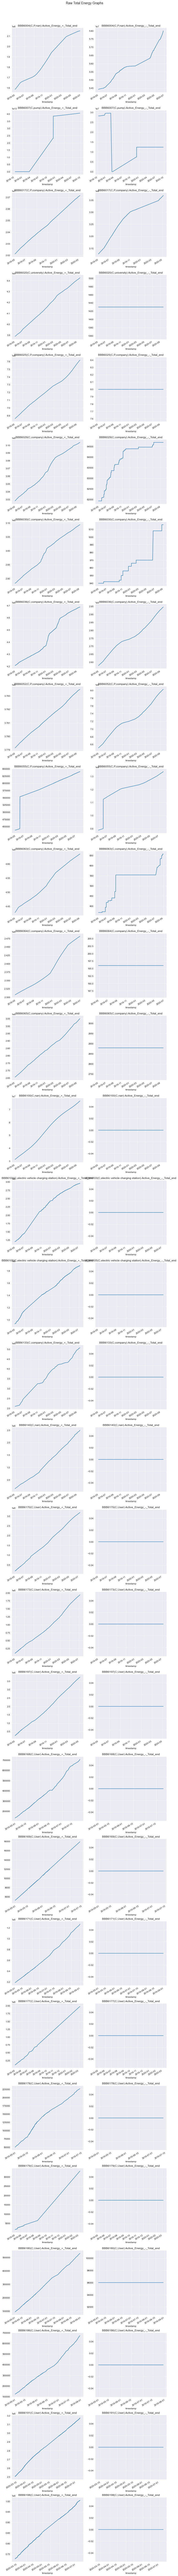

In [10]:
#for these smart meters multiply total active energy values before 2019-05-14T10:00:00Z by 10^3 and drop all readings before 2019-04-29 13:00:00
simple = ['BBB6004', 'BBB6017', 'BBB6020', 'BBB6025', 'BBB6065', 'BBB6100', 'BBB6103', 'BBB6105', 'BBB6133', 'BBB6140', 'BBB6170', 'BBB6173', 'BBB6197'] + somedata
for id in simple:
    df = dict[id]
    df2 = df[df.timestamp < '2019-05-14 10:00:00']   
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini'] * 1000
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end'] * 1000
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini'] * 1000
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end'] * 1000
    df.update(df2)
    df = df.drop(df[df.timestamp < '2019-04-29 13:00:00'].index)
    df = df.drop(df[df.timestamp > '2023-04-29 13:00:00'].index)
    df = df.drop(df[df['Active_Energy_+_Total_end']<1000].index)
    if(id == 'BBB6020' or id == 'BBB6025'): df = df.drop(df[df.timestamp < '2019-04-30 13:00:00'].index)
    dict[id] = df

#for these smart meters we assume after  is correct: (except for BBB6036 where that magnitude is multiplied by 10)
#check for later: BBB6036 has generation?
for id in ['BBB6036']:
    df = dict[id]
    df2 = df[df.timestamp < '2019-05-30 11:00:00'] 
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini']/60000
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end']/60000
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini']/60000
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end']/60000
    df.update(df2)
    df2 = df2[df2.timestamp < '2019-05-14 10:00:00'] 
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini'] * 1000 
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end'] * 1000 
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini'] * 1000 
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end'] * 1000 
    df.update(df2)
    
    
    df2 = df[df.timestamp > '2019-05-30 10:45:00']
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini'] * 10 
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end'] * 10
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini'] * 10
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end'] * 10 
    df.update(df2)
    
    dict[id] = df

for id in ['BBB6029']:
    df = dict[id]
    df2 = df[df.timestamp < '2019-05-24 13:00:00'] 
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini']/60000
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini']/60000
    df.update(df2)

    df2 = df[df.timestamp < '2019-05-24 12:45:00'] 
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end']/60000
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end']/60000
    df.update(df2)
   
    df2 = df2[df2.timestamp < '2019-05-14 10:00:00'] 
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini'] * 1000 
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end'] * 1000 
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini'] * 1000 
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end'] * 1000 
    df.update(df2)
    dict[id] = df



for id in ['BBB6055']:
    df = dict[id]
    df2 = df[df.timestamp < '2019-05-29 13:15:00'] 
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini']/30000
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end']/30000
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini']/30000
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end']/30000
    df.update(df2)

    df2 = df2[df2.timestamp < '2019-05-14 10:00:00'] 
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini'] * 1000 
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end'] * 1000 
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini'] * 1000 
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end'] * 1000 
    df.update(df2)
    
    #df2 = df2[df2.timestamp < '2019-05-30 10:30:00'] 
    #df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini'] * 1.25
    #df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end'] * 1.25 
    #df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini'] * 1.25 
    #df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end'] * 1.25 
    #df.update(df2)
    dict[id] = df

for id in ['BBB6063', 'BBB6064']:
    df = dict[id]
    df2 = df[df.timestamp < '2019-05-30 15:00:00'] 
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini']*2
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini']*2
    df.update(df2)

    df2 = df[df.timestamp < '2019-05-30 14:45:00'] 
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end']*2
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end']*2
    df.update(df2)

    df2 = df2[df2.timestamp < '2019-05-14 10:00:00'] 
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini'] * 1000 
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end'] * 1000 
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini'] * 1000 
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end'] * 1000 
    df.update(df2)

    dict[id] = df


for id in ['BBB6030']:
    df = dict[id]
    df2 = df[df['Active_Energy_+_Total_ini'] > 8000000000.0]
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini'] / 30
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini'] / 30
    df.update(df2)
    df2 = df[df['Active_Energy_+_Total_end'] > 8000000000.0]
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end'] / 30
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end'] / 30
    df.update(df2)

    df2 = df[df['Active_Energy_+_Total_ini'] > 288354648000.0]
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini'] / 1000
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini'] / 1000    
    df.update(df2)
    df2 = df[df['Active_Energy_+_Total_end'] > 288354648000.0]
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end'] / 1000
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end'] / 1000
    df.update(df2)
    
    dict[id] = df

for id in ['BBB6052']:
    df = dict[id]
    df2 = df[df.timestamp < '2019-05-14 10:00:00']   
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini'] * 1000
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end'] * 1000
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini'] * 1000
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end'] * 1000
    df.update(df2)

    df2 = df[df['Active_Energy_+_Total_ini'] < 300000000.0]
    df2['Active_Energy_+_Total_ini'] = df2['Active_Energy_+_Total_ini'] * 2
    df2['Active_Energy_-_Total_ini'] = df2['Active_Energy_-_Total_ini'] * 2   
    df.update(df2)
    df2 = df[df['Active_Energy_+_Total_end'] < 300000000.0]
    df2['Active_Energy_+_Total_end'] = df2['Active_Energy_+_Total_end'] * 2
    df2['Active_Energy_-_Total_end'] = df2['Active_Energy_-_Total_end'] * 2
    df.update(df2)
    
    dict[id] = df


fig, ax = plt.subplots(len(meters), 2, figsize=(10,len(meters)*5))
i = 0

for id in meters:
    meter = dict[id].copy()

    meter['Active_Energy_+_Total_end'].plot(ax=ax[i][0])
    meter['Active_Energy_-_Total_end'].plot(ax=ax[i][1])

    
    ax[i][0].set_title(id_title(id, meter_description) + ' Active_Energy_+_Total_end')
    ax[i][1].set_title(id_title(id, meter_description) + ' Active_Energy_-_Total_end')
    

    i=i+1

fig.tight_layout()
fig.subplots_adjust(top=0.97)
fig.suptitle('Raw Total Energy Graphs', fontsize=14)





In [11]:
for id in meters:
    one_meter = dict[id].copy()
    one_meter = one_meter.resample('15min').agg({'Active_Energy_+_Total_end':np.max, 'Active_Energy_-_Total_end':np.max})
    dict[id] = one_meter


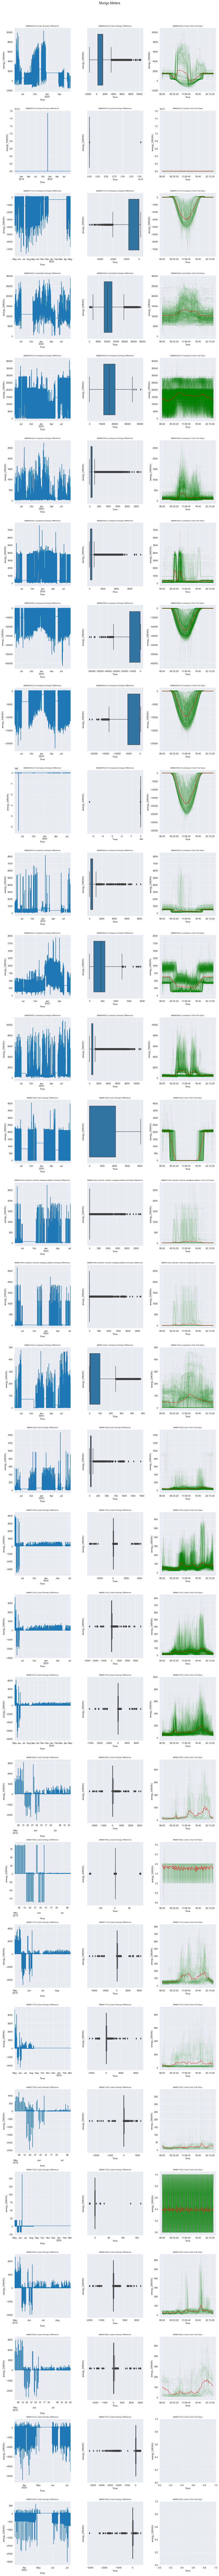

In [12]:
fig, ax = plt.subplots(len(meters), 3, figsize=(13,len(meters)*5))
i=0

matplotlib.rcParams.update({'axes.titlesize': 'small'})


for id in meters:
    one_meter = dict[id].copy()
    one_meter['isnull'] = one_meter['Active_Energy_+_Total_end'].isnull()
    one_meter['consecutive_null'] = one_meter['Active_Energy_+_Total_end'].isnull().astype(int).groupby(one_meter['Active_Energy_+_Total_end'].notnull().astype(int).cumsum()).cumsum()

    one_meter['Active_Energy_+_Total_end'] = one_meter['Active_Energy_+_Total_end'].interpolate()
    one_meter['Active_Energy_-_Total_end'] = one_meter['Active_Energy_-_Total_end'].interpolate()

    one_meter['energy_plus'] = one_meter['Active_Energy_+_Total_end'].diff()
    one_meter['energy_minus'] = one_meter['Active_Energy_-_Total_end'].diff()
    one_meter['energy_Diff'] = one_meter['energy_plus'] - one_meter['energy_minus']

    #plots:
    one_meter['energy_Diff'].plot(ax=ax[i][0])
    ax[i][0].set_ylabel("energy_Diff(Wh)")
    ax[i][0].set_xlabel("Time")
    ax[i][0].set_title(id_title(id,meter_description) + " Energy Difference")

    sns.boxplot(x = one_meter[one_meter['isnull']==False]['energy_Diff'], ax = ax[i][1])
    ax[i][1].set_ylabel("energy_Diff(Wh)")
    ax[i][1].set_xlabel("Time")
    ax[i][1].set_title(id_title(id,meter_description) + " Energy Difference")


    #impute every null value that is in the 00:00h to 00:06h interval and has consecutive_null < 24 using energy_difference 
    one_meter['hour'] = one_meter.index.hour
    missing_night = one_meter[one_meter['consecutive_null'].between(1,24)][one_meter['hour'].isin([0,1,2,3,4,5,6])]
    missing_night['isnull'] =  False
    one_meter.update(missing_night)

    #impute every null value that isn't more than 2 hours away from the last real value using energy_difference
    missing_lessthan2hours = one_meter[one_meter['consecutive_null'].isin([1, 8])]
    missing_lessthan2hours['isnull'] =  False
    one_meter.update(missing_lessthan2hours)

    #now select all days that have no null values after imputation
    one_meter['date'] = one_meter.index.date
    one_meter['time'] = one_meter.index.time
    full_days = one_meter.pivot(index='date', columns ='time', values='isnull')
    full_days = full_days.loc[~full_days[full_days.columns].any(True)]
    one_meter = one_meter[one_meter['date'].isin(full_days.index)]

    #exporting to CSV:
    one_meter = one_meter[['energy_Diff']]
    head, tail = os.path.split(dir_path)
    one_meter.to_csv(head + '/2_Clustering/in_CSV/Mongo/' + id + 'Mongo.csv')

    #some extra plots:
    df_pivot = one_meter.copy()
    df_pivot['date'] = df_pivot.index.date
    df_pivot['time'] = df_pivot.index.time
    df_pivot = df_pivot.pivot(index='time', columns='date', values='energy_Diff')
    mean_consumption = df_pivot.T.mean()
    print(df_pivot)
    if(not df_pivot.empty):
        df_pivot.plot(legend=False, color='green', alpha=0.05, ax = ax[i][2])
        mean_consumption.plot(ax=ax[i][2], color = 'red', ls='--')

    ax[i][2].set_ylabel("energy_Diff(Wh)")
    ax[i][2].set_xlabel("Time")
    ax[i][2].set_title(id_title(id,meter_description) + " Only Full Days")


    i = i +1

fig.tight_layout()
fig.subplots_adjust(top=0.97)
fig.suptitle('Mongo Meters', fontsize=14)
fig.savefig(dir_path+'/plots&graphs/Mongo_general_graphs')
    

For one smart meter: